# CYP21A2
The CYP21A2 gene encodes the 21-hydroxylase enzyme (EC 1.14.99.10), which is essential for adrenal steroidogenesis.
[Congenital adrenal hyperplasia](https://omim.org/entry/201910) is caused by homozygous or compound heterozygous mutation in the CYP21A2 gene.
In about 95% of cases, 21-hydroxylation is impaired in the zona fasciculata of the adrenal cortex so that 17-hydroxyprogesterone (17-OHP) is not converted to 11-deoxycortisol.

This notebook analyzes data curated from [Xu C, et al. (2019) Genotype-phenotype correlation study and mutational and hormonal analysis in a Chinese cohort with 21-hydroxylase deficiency. Mol Genet Genomic Med](https://pubmed.ncbi.nlm.nih.gov/30968594/). 

We will follow the authors with the
> assumption that the mildest mutation determines the phenotype in compound heterozygotes.

The authors measured Residual activity of the different mutant proteins in COS7 cells (See Figure 3). The variants with the highest residual activities were
I73N, V282L, P454S, and P483S (between 9.5-8%). One tested missense variant, H393Q, had a lower residual activity (2.2%). 

We will therefore use the CohortVariantViewer to show a table with all variants in the cohort and compare the missense variants with the rest with respect to
correlations with 17-OHP level. Note that not all missesne variants were tested, so we will also perform a test with just I73N, V282L, P454S, and P483S.


In [4]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


# CYP21A2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CYP21A2.

In [5]:
gene_symbol = 'CYP21A2'
mane_tx_id = 'NM_000500.9'
mane_protein_id = 'NP_000491.4' # steroid 21-hydroxylase isoform a [Homo sapiens]

In [6]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = "CYP21A2"	


cohort_creator = configure_caching_cohort_creator(hpo)
from gpsea.preprocessing import load_phenopacket_folder
pp_dir = '/Users/robin/GIT/phenopacket-store/notebooks/CYP21A2/phenopackets/'
cohort, qc_results = load_phenopacket_folder(pp_dir, cohort_creator)  
qc_results.summarize()



Individuals Processed: 69individuals [00:32,  2.11individuals/s]
Validated under permissive policy
No errors or warnings were found


In [7]:
from gpsea.view import CohortViewer
viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Increased circulating prolactin concentration,HP:0000870,47
Increased circulating ACTH level,HP:0003154,43
Hyperpigmentation of the skin,HP:0000953,41
Clitoral hypertrophy,HP:0008665,26
Decreased serum testosterone concentration,HP:0040171,23
Decreased circulating cortisol level,HP:0008163,23
Increased serum testosterone level,HP:0030088,18
Decreased serum estradiol,HP:0008214,18
Hirsutism,HP:0001007,4
Diarrhea,HP:0002014,4


In [8]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
6_32039081_32039081_C_G,c.293-13C>G,None,None,"splice polypyrimidine, intronic",35
SO:1000029_HGNC:2600_CYP21A2,SV involving CYP21A2,p.?,,chromosomal deletion,25
6_32039426_32039426_T_A,c.518T>A,p.Ile173Asn,4,missense,18
6_32040421_32040421_C_T,c.955C>T,p.Gln319Ter,8,stop gained,13
6_32040535_32040535_C_T,c.1069C>T,p.Arg357Trp,8,missense,5
6_32039132_32039140_GGAGACTAC_G,c.332_339del,p.Gly111ValfsTer21,3,frameshift,3
6_32038514_32038514_C_T,c.92C>T,p.Pro31Leu,1,missense,3
6_32040072_32040072_G_C,c.806G>C,p.Ser269Thr,7,missense,3
6_32040182_32040182_G_GT,c.923dup,p.Leu308PhefsTer6,7,frameshift,3
SO:1000037_HGNC:2600_CYP21A2,SV involving CYP21A2,p.?,,chromosomal duplication,2


<Axes: title={'center': 'Steroid 21-hydroxylase\ntranscript: NM_000500.9, protein: NP_000491.4'}>

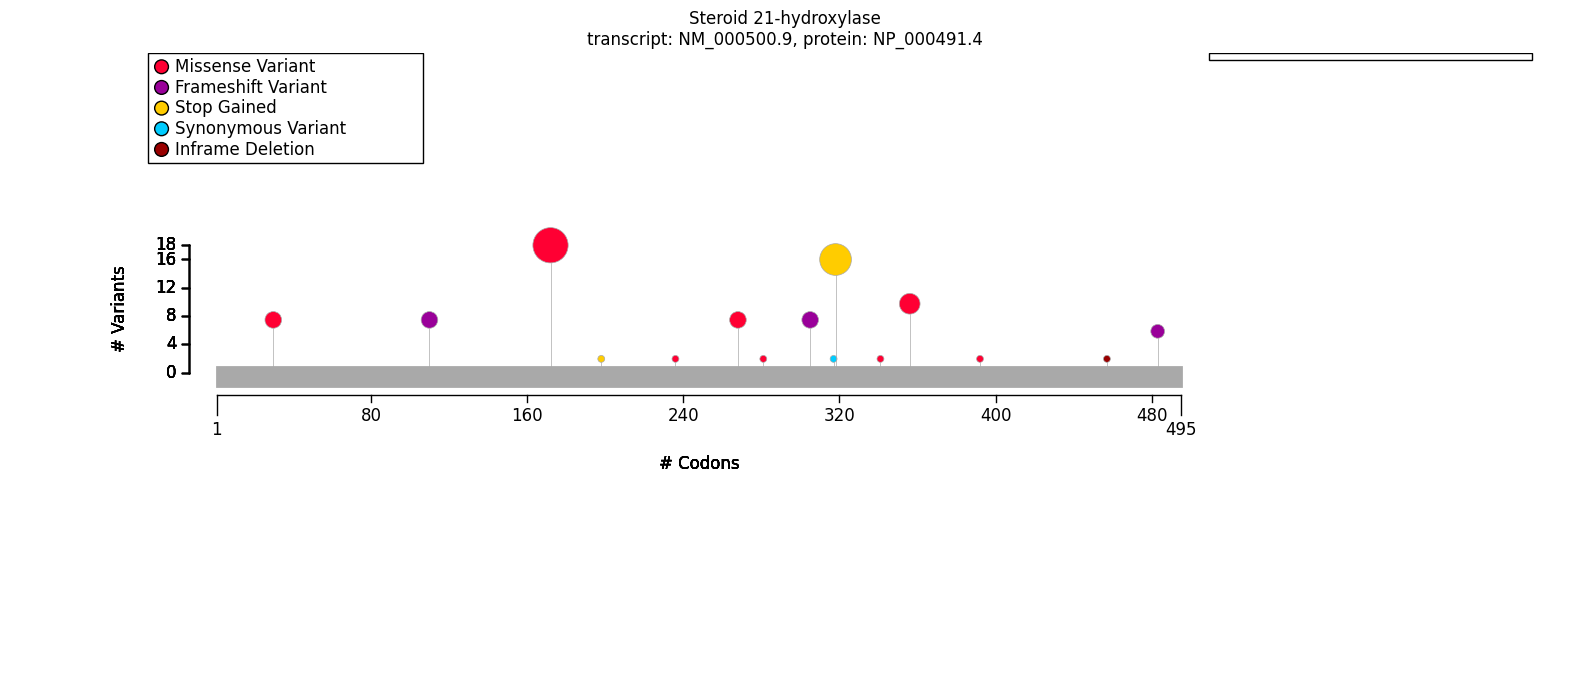

In [9]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizable, ProteinVisualizer

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

# Strategy
We will investigate whether a correlation can be found with variants associated with the salt-wasting phenotype (see above).
Recall the codes for [partitioning autosomal recessive variants](https://monarch-initiative.github.io/gpsea/stable/user-guide/predicates/mode_of_inheritance_predicate.html)
- No allele 0
- Monoallelic 1
- Biallelic 2

Therefore, for the following code:

```python
missense_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=i2g_variant,
    names=( "I2G", "missense"),
    partitions=((0,), (1,2,))
)
```
We are comparing the genotype of no missense alleles (0) vs. one missense/one I2G (1) or two missense (2)


In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates
from gpsea.analysis.predicate.genotype import biallelic_predicate


from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates
is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


two_missense_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="other",
    b_label= "missense",
    partitions=((0,), (1,2))
)

one_or_two_missense_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="other",
    b_label= "missense",
    partitions=((0,1), (2,))
)

#print(f"two missense predicate: {two_missense_predicate.display_question()}")
#print(f"one or two missense predicate: {one_or_two_missense_predicate.display_question()}")


#  

In [11]:
from gpsea.analysis.pscore import MeasurementPhenotypeScorer, PhenotypeScoreAnalysisResult
from gpsea.analysis.pscore.stats import TTestStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis
from gpsea.analysis.predicate.genotype import GenotypePolyPredicate
from gpsea.model import Cohort

def perform_t_test(loinc_id: str,
                   loinc_label: str,
                   cohort: Cohort,
                   gt_predicate: GenotypePolyPredicate) -> PhenotypeScoreAnalysisResult:
    pheno_scorer = MeasurementPhenotypeScorer.from_measurement_id( term_id=loinc_id,label=loinc_label )
    score_statistic = TTestStatistic()
    score_analysis = PhenotypeScoreAnalysis(
        score_statistic=score_statistic,
    )
    result = score_analysis.compare_genotype_vs_phenotype_score(
        cohort=cohort,
        gt_predicate=gt_predicate,
        pheno_scorer=pheno_scorer,
    )
    return result

# 17-Hydroxyprogesterone
We use the LOINC code for "17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma", [LOINC:1668-3](https://loinc.org/1668-3).

In [12]:
loinc_id ="LOINC:1668-3"
loinc_label = "17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma"
result_1_or_2_missense_17hp = perform_t_test(loinc_id=loinc_id, loinc_label=loinc_label, cohort=cohort, gt_predicate=one_or_two_missense_predicate)
print(f"missense (1 or 2): t test for {loinc_label}({loinc_id}): {result_1_or_2_missense_17hp.pval}")
result_2_missense_17hp = perform_t_test(loinc_id=loinc_id, loinc_label=loinc_label, cohort=cohort, gt_predicate=two_missense_predicate)
print(f"missense (2): t test for {loinc_label}({loinc_id}): {result_2_missense_17hp.pval}")


missense (1 or 2): t test for 17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma(LOINC:1668-3): 7.911005915423105e-06
missense (2): t test for 17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma(LOINC:1668-3): 0.03819549467408675


### Note that some of the individuals do not have values for 17OHP (See the following cell). The GPSEA code omits None values for the t-test, but we will
need to remove them to plot the values.

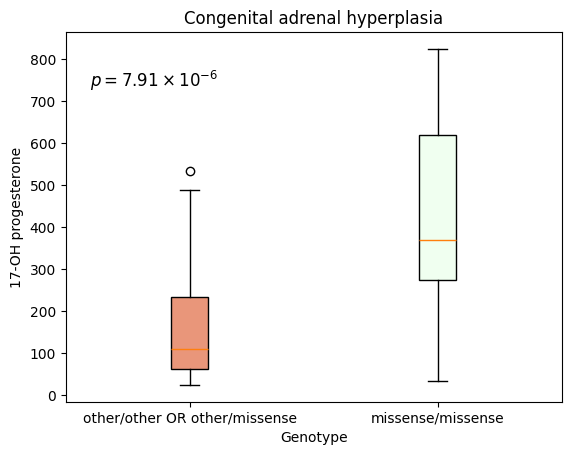

In [13]:
import matplotlib.pyplot as plt

# Create a figure and an axis
fig, ax = plt.subplots()
result_1_or_2_missense_17hp.plot_boxplots(ax=ax)
ax.set_xlabel('Genotype')
ax.set_ylabel('17-OH progesterone')
ax.set_title('Congenital adrenal hyperplasia')
ax.text(0.05, 0.9, r'$p = 7.91 \times 10^{-6}$', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left')
plt.savefig("cyp21a2.pdf", format="pdf")

TypeError: PhenotypeScoreAnalysisResult.plot_boxplots() got an unexpected keyword argument 'gt_predicate'

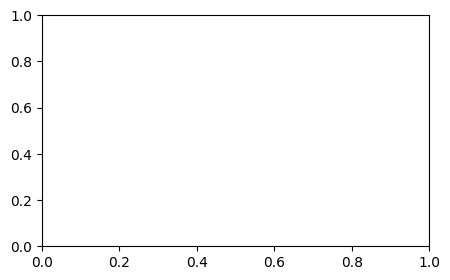

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3))
result_1_or_2_missense_17hp.plot_boxplots(gt_predicate=result_1_or_2_missense_17hp, ax=ax)

In [ ]:
scores = result_1_or_2_missense_17hp.genotype_phenotype_scores.sort_index()
scores.head()  

AttributeError: 'PhenotypeScoreAnalysisResult' object has no attribute 'genotype_phenotype_scores'

In [ ]:
filtered_df = scores[scores['phenotype'].notnull()]
filtered_df = scores[scores['genotype'].notnull()]
plt.style.use('ggplot')
plt.figure(figsize=(5, 3))

import seaborn as sns
my_palette = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC949', '#AF7AA1']

# Apply the custom palette in seaborn
sns.set_palette(my_palette)
sns.set_style('whitegrid')
ax = sns.boxplot(x='genotype',y='phenotype',data=filtered_df).set(
    xlabel='Genotype', 
    ylabel='17-Hydroxyprogesterone'
)
ax = sns.stripplot(x="genotype", y="phenotype",data=filtered_df)
ax.set_xlabel('')
labels = ax.get_xticklabels()
ax.set_xticks([0, 1])
new_labels = ["missense (1 or 2)", "other"]
ax.set_xticklabels(new_labels)
plt.savefig("t-test-CYP21A2-17OHP.pdf")
plt.savefig("t-test-CYP21A2-17OHP.png")

# Create a PDF file to show the table of variant effects
TEMP 

In [ ]:
var_effects_list = list()
data_by_tx = cohort.variant_effect_count_by_tx(tx_id=mane_tx_id)
for tx_id, counter in data_by_tx.items():
    if tx_id == mane_tx_id:
        for effect, count in counter.items():
            var_effects_list.append({"effect": effect, "count": count})

In [ ]:
import pandas as pd
df = pd.DataFrame(var_effects_list)
df.head()

In [ ]:
total = df["count"].sum()
df["Percent"] = df["count"].apply(lambda x: f"{round(100*x/100)}%")
df = df.sort_values(by='count', ascending=False)
df.rename(columns={
    'effect': 'Variant effect',
    'count': 'Count',
    'Frequency (%)': 'Frequency'
}, inplace=True)
df.head(20)

In [ ]:
df['Variant effect'] = df['Variant effect'].replace("SPLICE_POLYPYRIMIDINE_TRACT_VARIANT", "polypyrimidine tract")
df['Variant effect'] = df['Variant effect'].replace("INTRON_VARIANT", "intron")
df['Variant effect'] = df['Variant effect'].replace("INTRON_VARIANT", "intron")
df['Variant effect'] = df['Variant effect'].replace("MISSENSE_VARIANT", "missense")
df['Variant effect'] = df['Variant effect'].replace("TRANSCRIPT_ABLATION", "transcript ablation")
df['Variant effect'] = df['Variant effect'].replace("STOP_GAINED", "stop gained")
df['Variant effect'] = df['Variant effect'].replace("FRAMESHIFT_VARIANT", "frameshift")
df['Variant effect'] = df['Variant effect'].replace("INFRAME_DELETION", "inframe deletion")
df['Variant effect'] = df['Variant effect'].replace("UPSTREAM_GENE_VARIANT", "upstream gene variant")
df['Variant effect'] = df['Variant effect'].replace("TRANSCRIPT_AMPLIFICATION", "transcript amplification")
df['Variant effect'] = df['Variant effect'].replace("SYNONYMOUS_VARIANT", "synonymous")

NameError: name 'df' is not defined

In [ ]:
# Create a matplotlib figure
fig, ax = plt.subplots(figsize=(6, 3))  # Adjust size as needed

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Set header color to light blue
header_color = '#ADD8E6'  # Light blue
for j in range(len(df.columns)):
    table[0, j].set_facecolor(header_color)
    table[0, j].set_text_props(weight='bold')  # Make headers bold

# Alternate row colors
for i in range(len(df)):
    color = '#FFFFFF' if i % 2 == 0 else '#F0F0F0'  # White and very light grey
    for j in range(len(df.columns)):
        table[i + 1, j].set_facecolor(color)

# Set column widths
table.auto_set_column_width([0, 1, 2])  # Auto set widths for all columns
table.scale(1.5, 1.5)  # Adjust scaling as needed

# Adjust individual column widths (e.g., set first column wider)
table[0, 0].set_width(0.2)  # Set width for the first column
table[0, 1].set_width(0.1)  # Set width for the second column
table[0, 2].set_width(0.1)  # Set width for the third column

# Adjust the table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Adjust scaling as needed

# Save as PDF
plt.savefig("styled_table.pdf", bbox_inches='tight', pad_inches=0.1)
plt.savefig("styled_table.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

